In [5]:
pip install requests beautifulsoup4

Note: you may need to restart the kernel to use updated packages.


In [18]:
!pip install biopython pandas matplotlib seaborn nglview

  Using cached biopython-1.84-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 22.2 MB/s eta 0:00:00 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Using cached biopython-1.84-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.2 MB)
  Created wheel for nglview: filename=nglview-3.1.2-py3-none-any.whl size=7493364 sha256=5363601d6634bc91dc558c20aa0ce99654614a33797d4229aa479c319051535a
  Stored in directory: /home/cesco345/.cache/pip/wheels/32/93/65/e478e673dec5b2c01432b856358725e7cea75beeaca850edab
Successfully built nglview


In [19]:
import requests
import xml.etree.ElementTree as ET
import re
import time

def search_pubmed(query, retmax=100):
    print(f"Searching PubMed for query: '{query}'")
    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
    params = {
        "db": "pubmed",
        "term": query,
        "retmax": retmax,
        "retmode": "xml",
        "sort": "relevance"
    }
    response = requests.get(base_url, params=params)
    root = ET.fromstring(response.content)
    id_list = [id_elem.text for id_elem in root.findall(".//Id")]
    print(f"Found {len(id_list)} PubMed IDs")
    return id_list

def fetch_abstracts(id_list):
    print(f"Fetching abstracts for {len(id_list)} PubMed IDs")
    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
    params = {
        "db": "pubmed",
        "id": ",".join(id_list),
        "retmode": "xml"
    }
    response = requests.get(base_url, params=params)
    root = ET.fromstring(response.content)
    abstracts = []
    for article in root.findall(".//Article"):
        abstract = article.find(".//Abstract/AbstractText")
        if abstract is not None and abstract.text:
            abstracts.append(abstract.text)
    print(f"Successfully fetched {len(abstracts)} abstracts")
    return abstracts

def extract_pdb_ids(text):
    pdb_pattern = r'\b[1-9][A-Za-z0-9]{3}\b'
    return re.findall(pdb_pattern, text)

def validate_pdb_ids(pdb_ids):
    valid_ids = []
    for pdb_id in pdb_ids:
        url = f"https://data.rcsb.org/rest/v1/core/entry/{pdb_id}"
        response = requests.get(url)
        if response.status_code == 200:
            valid_ids.append(pdb_id)
    return valid_ids

def main():
    print("Starting Alzheimer's-related PDB ID extraction from PubMed")
    
    queries = [
        "Alzheimer's disease (BACE1 OR APP OR PSEN1 OR PSEN2 OR APOE OR MAPT) PDB",
        "Alzheimer's disease protein structure",
        "Alzheimer's disease drug target structure"
    ]
    
    all_pdb_ids = set()

    for query in queries:
        print(f"\nProcessing query: {query}")
        pmids = search_pubmed(query)
        
        if not pmids:
            print("No PubMed IDs found for this query. Moving to next query.")
            continue
        
        abstracts = fetch_abstracts(pmids)
        
        if not abstracts:
            print("No abstracts found for the PubMed IDs. Moving to next query.")
            continue
        
        pdb_ids = set()
        for abstract in abstracts:
            ids_in_abstract = extract_pdb_ids(abstract)
            pdb_ids.update(ids_in_abstract)
        
        print(f"Extracted PDB IDs: {pdb_ids}")
        valid_pdb_ids = validate_pdb_ids(pdb_ids)
        print(f"Validated PDB IDs: {valid_pdb_ids}")
        
        all_pdb_ids.update(valid_pdb_ids)
        
        print("Waiting for 1 second before next query...")
        time.sleep(1)  # Be nice to the NCBI servers

    print(f"\nSearch complete. Total unique valid PDB IDs found across all queries: {len(all_pdb_ids)}")
    print(f"All unique valid PDB IDs: {list(all_pdb_ids)}")

if __name__ == "__main__":
    main()

Starting Alzheimer's-related PDB ID extraction from PubMed

Processing query: Alzheimer's disease (BACE1 OR APP OR PSEN1 OR PSEN2 OR APOE OR MAPT) PDB
Searching PubMed for query: 'Alzheimer's disease (BACE1 OR APP OR PSEN1 OR PSEN2 OR APOE OR MAPT) PDB'
Found 74 PubMed IDs
Fetching abstracts for 74 PubMed IDs
Successfully fetched 74 abstracts
Extracted PDB IDs: {'7184', '6000', '2008', '2016', '1000', '2012', '1817', '4one', '2002', '4I1H', '5SP4', '3R1G', '2HM1', '1998', '2006', '5O3L', '2FDP', '1IYT', '2V5Z', '5KK3', '1999', '6EQM', '2013', '4DJx'}
Validated PDB IDs: ['4one', '4I1H', '5SP4', '3R1G', '2HM1', '5O3L', '2FDP', '1IYT', '2V5Z', '5KK3', '6EQM', '4DJx']
Waiting for 1 second before next query...

Processing query: Alzheimer's disease protein structure
Searching PubMed for query: 'Alzheimer's disease protein structure'
Found 100 PubMed IDs
Fetching abstracts for 100 PubMed IDs
Successfully fetched 99 abstracts
Extracted PDB IDs: {'2030', '1995', '2050', '1907'}
Validated PDB I

In [21]:
# Alzheimer's Protein Structure Analysis

import os
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.PDB import PDBParser, PDBIO, Superimposer, NeighborSearch, Select
import numpy as np
import warnings

warnings.filterwarnings("ignore")

# Cell 1: Define PDB IDs and download structures
pdb_ids = ['4I1H', '5SP4', '5KK3', '3R1G', '1IYT', '5O3L', '6EQM', '4DJx', '2FDP', '2HM1', '2V5Z', '4one']

output_dir = "./alzheimers_structures"
os.makedirs(output_dir, exist_ok=True)

for pdb_id in pdb_ids:
    pdb_url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    try:
        output_path = os.path.join(output_dir, f"{pdb_id}.pdb")
        urllib.request.urlretrieve(pdb_url, output_path)
        print(f"Downloaded {pdb_id}.pdb")
    except Exception as e:
        print(f"Error downloading {pdb_id}: {e}")


Downloaded 4I1H.pdb
Downloaded 5SP4.pdb
Downloaded 5KK3.pdb
Downloaded 3R1G.pdb
Downloaded 1IYT.pdb
Downloaded 5O3L.pdb
Downloaded 6EQM.pdb
Downloaded 4DJx.pdb
Downloaded 2FDP.pdb
Downloaded 2HM1.pdb
Downloaded 2V5Z.pdb
Downloaded 4one.pdb


In [30]:
# Cell 2: Parse PDB structures
parser = PDBParser()
structures = [parser.get_structure(pdb_id, os.path.join(output_dir, f"{pdb_id}.pdb")) for pdb_id in pdb_ids]

In [34]:
# Cell 3: Identify potential binding sites
def get_ca_atoms(structure):
    return [atom for atom in structure.get_atoms() if atom.name == 'CA']

def find_pockets(ca_atoms, probe_radius=5.0):
    coords = np.array([atom.coord for atom in ca_atoms])
    tri = Delaunay(coords)
    
    pockets = []
    for simplex in tri.simplices:
        points = coords[simplex]
        center = points.mean(axis=0)
        radius = np.linalg.norm(points - center, axis=1).max()
        if radius > probe_radius:
            pockets.append((center, radius))
    
    return sorted(pockets, key=lambda x: x[1], reverse=True)

def get_pocket_residues(structure, pocket_center, pocket_radius):
    return [atom.get_parent() for atom in structure.get_atoms() 
            if np.linalg.norm(atom.coord - pocket_center) <= pocket_radius]

In [36]:
from scipy.spatial import Delaunay
# Cell 4: Extract potential binding sites
binding_sites = []
for pdb_id, structure in zip(pdb_ids, structures):
    print(f"\nProcessing {pdb_id}")
    ca_atoms = get_ca_atoms(structure)
    if not ca_atoms:
        print(f"No CA atoms found in {pdb_id}")
        binding_sites.append([])
        continue
    
    pockets = find_pockets(ca_atoms)
    if not pockets:
        print(f"No pockets found in {pdb_id}")
        binding_sites.append([])
        continue
    
    largest_pocket = pockets[0]
    pocket_residues = get_pocket_residues(structure, largest_pocket[0], largest_pocket[1])
    print(f"Found potential binding site for {pdb_id} with {len(pocket_residues)} residues")
    binding_sites.append(pocket_residues)


Processing 4I1H
Found potential binding site for 4I1H with 2488 residues

Processing 5SP4
Found potential binding site for 5SP4 with 1849 residues

Processing 5KK3
Found potential binding site for 5KK3 with 31964 residues

Processing 3R1G
Found potential binding site for 3R1G with 5789 residues

Processing 1IYT
Found potential binding site for 1IYT with 5538 residues

Processing 5O3L
Found potential binding site for 5O3L with 11290 residues

Processing 6EQM
Found potential binding site for 6EQM with 1185 residues

Processing 4DJx
Found potential binding site for 4DJx with 4268 residues

Processing 2FDP
Found potential binding site for 2FDP with 6995 residues

Processing 2HM1
Found potential binding site for 2HM1 with 1130 residues

Processing 2V5Z
Found potential binding site for 2V5Z with 3296 residues

Processing 4one
Found potential binding site for 4one with 2394 residues


In [37]:
# Cell 5: Calculate RMSD matrix
def calc_rmsd_matrix(binding_sites):
    num_structures = len(binding_sites)
    rmsd_matrix = np.zeros((num_structures, num_structures))
    for i in range(num_structures):
        for j in range(i, num_structures):
            if i == j:
                rmsd_matrix[i, j] = 0.0
            else:
                fixed = binding_sites[i]
                moving = binding_sites[j]
                if fixed and moving:
                    fixed_coords = np.array([res['CA'].coord for res in fixed if res.has_id('CA')])
                    moving_coords = np.array([res['CA'].coord for res in moving if res.has_id('CA')])
                    if len(fixed_coords) > 0 and len(moving_coords) > 0:
                        min_length = min(len(fixed_coords), len(moving_coords))
                        rmsd = np.sqrt(np.sum((fixed_coords[:min_length] - moving_coords[:min_length])**2) / min_length)
                        rmsd_matrix[i, j] = rmsd
                        rmsd_matrix[j, i] = rmsd
                    else:
                        rmsd_matrix[i, j] = np.nan
                        rmsd_matrix[j, i] = np.nan
                else:
                    rmsd_matrix[i, j] = np.nan
                    rmsd_matrix[j, i] = np.nan
    return rmsd_matrix

rmsd_matrix = calc_rmsd_matrix(binding_sites)

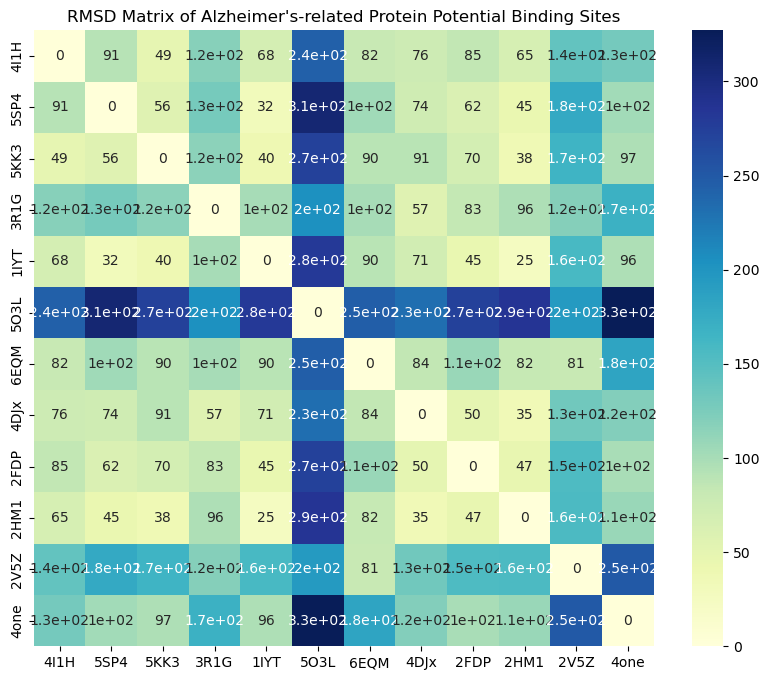

In [38]:
# Cell 6: Visualize RMSD matrix
plt.figure(figsize=(10, 8))
sns.heatmap(rmsd_matrix, annot=True, cmap="YlGnBu", xticklabels=pdb_ids, yticklabels=pdb_ids)
plt.title("RMSD Matrix of Alzheimer's-related Protein Potential Binding Sites")
plt.show()

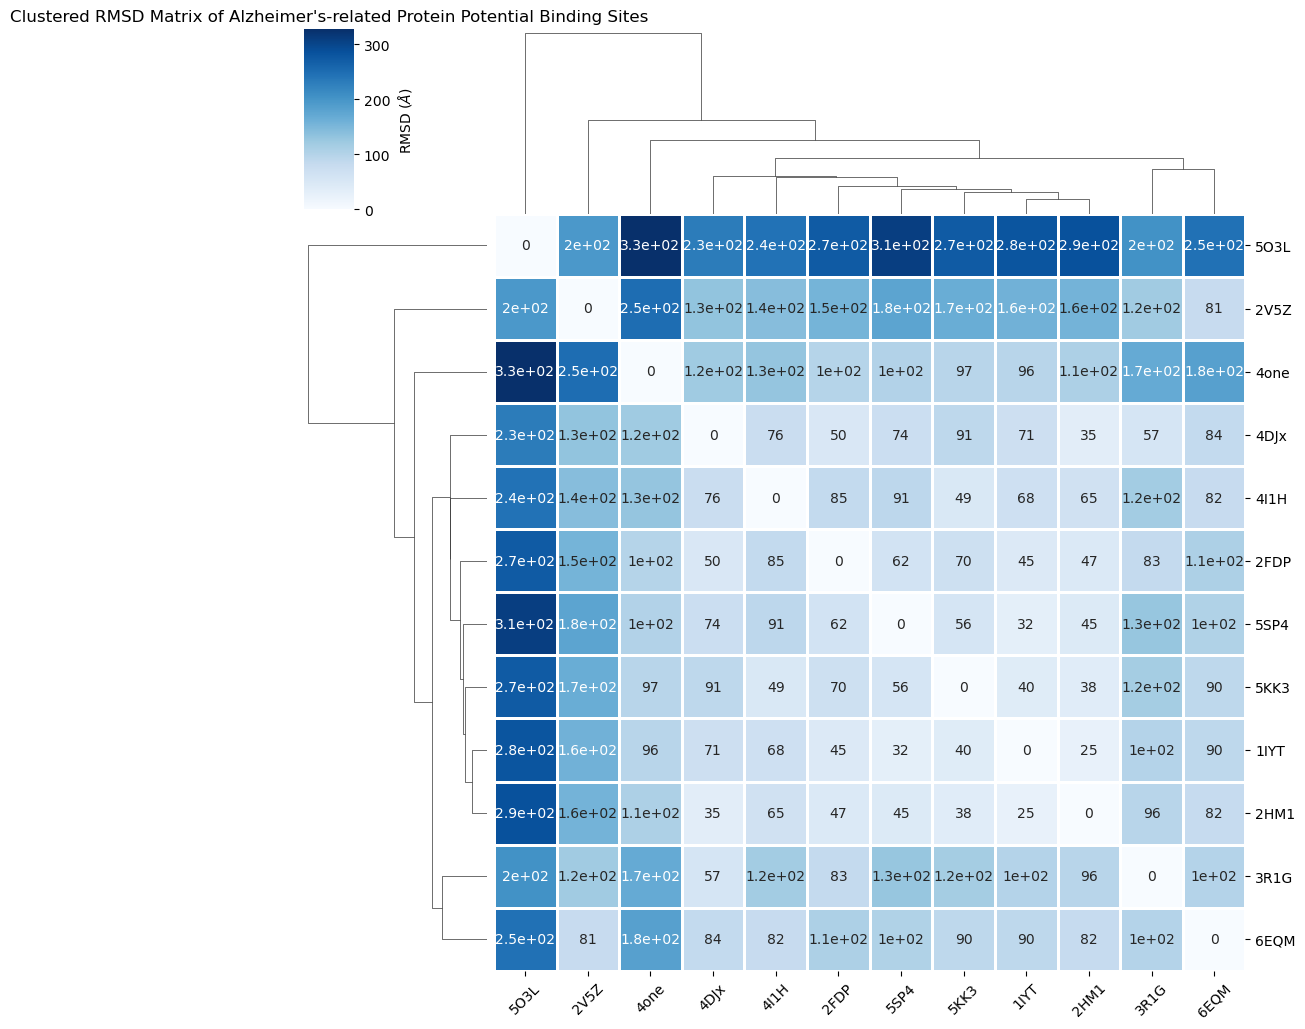

In [39]:
# Cell 7: Cluster RMSD matrix
def plot_clustermap(rmsd):
    g = sns.clustermap(
        rmsd,
        linewidths=1,
        annot=True,
        cbar_kws={"label": "RMSD ($\AA$)"},
        cmap="Blues",
    )
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45)
    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
    plt.title("Clustered RMSD Matrix of Alzheimer's-related Protein Potential Binding Sites")
    plt.show()

plot_clustermap(pd.DataFrame(rmsd_matrix, index=pdb_ids, columns=pdb_ids))

# Alzheimer's Protein Structure Analysis: Binding Site Identification and Comparison

This analysis focuses on identifying and comparing potential binding sites in protein structures related to Alzheimer's disease. By examining structural similarities and differences among these proteins, we aim to gain insights that could guide the design of new potential inhibitors for Alzheimer's treatment. This approach complements other drug discovery methods by providing a structural perspective on potential drug targets.

## 1. Data Acquisition and Preprocessing

We start by downloading PDB files for a set of protein structures related to Alzheimer's disease, including BACE1, APP, and other relevant proteins.

Understanding the structural details of these proteins is crucial for Alzheimer's research. These structures represent key proteins involved in Alzheimer's pathology, and analyzing their structural features is essential for understanding potential drug binding sites and mechanisms of action.

## 2. Structure Parsing

We parse the downloaded PDB files to extract structural information.

Parsing the PDB files allows us to work with the structural data programmatically, enabling detailed analysis of atomic coordinates and protein topology. This step is fundamental for any computational analysis of protein structures.

## 3. Potential Binding Site Identification

We identify potential binding sites using a pocket detection algorithm based on Delaunay triangulation.

Identifying potential binding sites is crucial for drug design. This method detects pockets in the protein structure that could accommodate ligands, which are often the sites where drugs bind and exert their effects. Understanding these sites can guide the design of new, potentially more effective compounds for Alzheimer's treatment.

## 4. Binding Site Extraction

We extract the residues surrounding the largest detected pocket for each structure.

Focusing on the largest pocket is a common strategy in drug design, as these are often the most likely sites for drug binding. Extracting the surrounding residues allows us to analyze the chemical environment of the potential binding site, which is crucial for understanding protein-ligand interactions.

## 5. RMSD Calculation

We calculate the Root Mean Square Deviation (RMSD) between the potential binding sites of different structures.

RMSD provides a quantitative measure of structural similarity between binding sites. Lower RMSD values indicate more similar geometries, which could suggest similar binding properties or evolutionary relationships between proteins. This information is valuable for understanding the diversity of binding sites across different Alzheimer's-related proteins.

## 6. Visualization of RMSD Matrix

We visualize the RMSD matrix using a heatmap.

Heatmap visualization allows for quick identification of structural similarities and differences across the analyzed proteins. This can reveal clusters of related structures and outliers that might have unique binding properties, providing insights into the relationships between different Alzheimer's-related proteins.

## 7. Hierarchical Clustering

We perform hierarchical clustering on the RMSD matrix.

Clustering helps identify groups of proteins with similar binding site geometries. This can suggest functional relationships or common binding modes, which is valuable for understanding protein function and guiding drug design efforts. It may reveal unexpected similarities between proteins that could inform new therapeutic strategies.

## 8. Result Analysis and Next Steps

We analyze the results and outline next steps for further investigation.

Interpreting the results in the context of Alzheimer's research is crucial for extracting meaningful insights. The analysis can reveal:
1. Which structures have similar potential binding sites, suggesting similar drug binding properties.
2. Outliers that might represent unique conformations or different protein targets, potentially leading to novel drug design approaches.
3. Common structural features among binding sites that could be crucial for drug interactions.

Next steps include:
1. Investigating structures with high similarity to understand common binding features.
2. Analyzing outlier structures to identify unique characteristics that might be relevant to drug design.
3. Comparing potential binding sites of different protein targets (e.g., BACE1 vs APP) to understand target specificity.
4. Using this information to guide the design of new potential inhibitors for Alzheimer's treatment.
5. Considering more advanced binding site prediction tools for further validation.

This structural analysis provides valuable insights that can guide future drug discovery efforts for Alzheimer's disease, complementing other approaches in the field.